In [ ]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd


file_path = '/content/drive/MyDrive/Colab Notebooks/Levine_32dim_notransform.csv'
df = pd.read_csv(file_path)
df.head()
df_original=df
df.columns


Index(['Time', 'Cell_length', 'DNA1', 'DNA2', 'CD45RA', 'CD133', 'CD19',
       'CD22', 'CD11b', 'CD4', 'CD8', 'CD34', 'Flt3', 'CD20', 'CXCR4',
       'CD235ab', 'CD45', 'CD123', 'CD321', 'CD14', 'CD33', 'CD47', 'CD11c',
       'CD7', 'CD15', 'CD16', 'CD44', 'CD38', 'CD13', 'CD3', 'CD61', 'CD117',
       'CD49d', 'HLA-DR', 'CD64', 'CD41', 'Viability', 'file_number',
       'event_number', 'label', 'individual'],
      dtype='object')

In [ ]:
df = df.drop(columns=['Time','file_number', 'event_number'])

len(df.columns)


38

In [ ]:
import numpy as np
import pandas as pd

def create_corrupted_data(data, keep_probability=0.4):
    print("Original Data (x):\n", data)

    m = np.random.binomial(1, keep_probability, size=data.shape)
    print("\nBinary Mask (m):\n", m)

    num_rows = data.shape[0]
    shuffled_rows = np.random.permutation(num_rows)
    x_shuffled = data.iloc[shuffled_rows].reset_index(drop=True)
    print("\nShuffled Data (x_shuffled):\n", x_shuffled)


    x_corrupted = data * (1 - m) + x_shuffled * m
    print("\nCorrupted Data (x_corrupted):\n", x_corrupted)

    return x_corrupted

# Sample data
data = pd.DataFrame({
    'A': [1, 2, 3, 4, 5],
    'B': [6, 7, 8, 9, 10],
    'C': [11, 12, 13, 14, 15],
    'D': [16, 17, 18, 19, 20]
})

# Call the function
corrupted_data = create_corrupted_data(data, keep_probability=0.6)


Original Data (x):
    A   B   C   D
0  1   6  11  16
1  2   7  12  17
2  3   8  13  18
3  4   9  14  19
4  5  10  15  20

Binary Mask (m):
 [[0 1 1 1]
 [0 0 0 0]
 [1 1 1 0]
 [0 0 0 1]
 [1 0 1 0]]

Shuffled Data (x_shuffled):
    A   B   C   D
0  5  10  15  20
1  4   9  14  19
2  2   7  12  17
3  3   8  13  18
4  1   6  11  16

Corrupted Data (x_corrupted):
    A   B   C   D
0  1  10  15  20
1  2   7  12  17
2  2   7  12  18
3  4   9  14  18
4  1  10  11  20


In [ ]:
corrupted_data = create_corrupted_data(df, keep_probability=0.4)

corrupted_data.head()

Original Data (x):
         Cell_length         DNA1         DNA2     CD45RA     CD133      CD19  \
0                22   201.783295   253.016647   0.817049 -0.147947 -0.033482   
1                35   191.828598   308.869080   3.801385 -0.191446 -0.083274   
2                32   116.111923   200.839218   3.204439 -0.161106  0.369613   
3                29   176.248505   313.022461   2.237382 -0.138071 -0.088311   
4                25   133.332779   226.467758  -0.044047 -0.151509  0.402548   
...             ...          ...          ...        ...       ...       ...   
265622           41  2305.191162  3131.641357  10.345075 -0.095875 -0.278241   
265623           45  2217.376953  3198.114258   0.585101 -0.281215 -0.044320   
265624           41  2455.673340  3157.416260   3.698715 -0.031322 -0.130569   
265625           39  2395.883789  3167.325439   1.463955 -0.056550 -0.244025   
265626           41  2450.653320  3113.955078   1.843143  0.644794 -0.034668   

            CD22   

,Cell_length,DNA1,DNA2,CD45RA,CD133,CD19,CD22,CD11b,CD4,CD8,...,CD3,CD61,CD117,CD49d,HLA-DR,CD64,CD41,Viability,label,individual
0,22,156.882050,197.364685,2.872423,-0.102512,-0.033482,0.332183,0.316677,0.410720,2.719878,...,277.852600,-0.014681,0.666451,4.804858,0.309933,-0.026878,-0.219736,2.130968,NaN,1
1,35,191.828598,308.869080,3.801385,-0.191446,1.769786,0.372388,4.494379,-0.177158,77.753540,...,-0.217398,-0.125753,0.448901,0.995556,2.558165,0.726602,-0.196756,2.956692,1.0,1
2,36,172.271713,200.839218,3.204439,-0.161106,0.369613,-0.214952,24.451731,-0.043904,-0.028160,...,1.631609,12.714215,0.231194,33.025459,10.335093,16.318913,10.131514,1.759936,1.0,1
3,29,2138.317871,313.022461,2.237382,-0.138071,-0.088311,-0.220430,0.878098,-0.095335,60.037422,...,0.302398,-0.205759,0.332596,8.879428,1.050080,-0.067247,-0.262394,-0.035651,NaN,1
4,25,133.332779,3058.924316,4.810705,-0.151509,8.962624,2.581769,6.742060,2.906627,0.156578,...,-0.226295,0.847043,-0.259410,2.633320,0.993077,0.381205,-0.202496,1.435457,9.0,2


In [ ]:
keep_probability=0.4
df_corrupted = np.random.binomial(1, keep_probability, size=df.shape)
print("\nBinary Mask (m):\n", df_corrupted)
mask_new = 1*(df!=df_corrupted)
print("\n New Binary Mask (m):\n",mask_new)


Binary Mask (m):
 [[0 1 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]
 [1 0 1 ... 0 0 0]
 ...
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 1 1]
 [1 1 0 ... 0 0 0]]

 New Binary Mask (m):
         Cell_length  DNA1  DNA2  CD45RA  CD133  CD19  CD22  CD11b  CD4  CD8  \
0                 1     1     1       1      1     1     1      1    1    1   
1                 1     1     1       1      1     1     1      1    1    1   
2                 1     1     1       1      1     1     1      1    1    1   
3                 1     1     1       1      1     1     1      1    1    1   
4                 1     1     1       1      1     1     1      1    1    1   
...             ...   ...   ...     ...    ...   ...   ...    ...  ...  ...   
265622            1     1     1       1      1     1     1      1    1    1   
265623            1     1     1       1      1     1     1      1    1    1   
265624            1     1     1       1      1     1     1      1    1    1   
265625            1     1     1       1      1 

In [ ]:

df_labeled = df[df['label'].notna()]
df_unlabeled = df[df['label'].isna()]


x_labeled = df_labeled.drop(columns=['label'])
y_labeled = df_labeled['label']

x_unlabeled = df_unlabeled.drop(columns=['label'])
#y_unlabeled = df_unlabeled['label']


print("Labeled Features (x_labeled):\n", x_labeled)
print("\nUnlabeled Features (x_unlabeled):\n", x_unlabeled)
print("\nLabeled Target (y_labeled):\n", y_labeled)

#print("\nUnlabeled Target (y_unlabeled):\n", y_unlabeled)


Labeled Features (x_labeled):
         Cell_length         DNA1         DNA2    CD45RA     CD133       CD19  \
0                22   201.783295   253.016647  0.817049 -0.147947  -0.033482   
1                35   191.828598   308.869080  3.801385 -0.191446  -0.083274   
2                32   116.111923   200.839218  3.204439 -0.161106   0.369613   
3                29   176.248505   313.022461  2.237382 -0.138071  -0.088311   
4                25   133.332779   226.467758 -0.044047 -0.151509   0.402548   
...             ...          ...          ...       ...       ...        ...   
104179           58  2308.310303  3518.157471 -0.000532 -0.153228   9.874423   
104180           55  1997.182739  3237.193604  3.747007 -0.186719  12.390443   
104181           40  2509.493408  3193.563232 -0.184019 -0.072385  12.375916   
104182           48  2031.685425  3032.251953  1.568744  0.379171  10.129170   
104183           64  1764.721802  2972.677002  2.716329  0.487051   8.959737   

        

In [ ]:
from sklearn.model_selection import train_test_split

# Split labeled data into training (70%) and testing (30%) sets
x_train, x_test, y_train, y_test = train_test_split(x_labeled, y_labeled, test_size=0.3, random_state=42)

# Display the results

print("Training Features (x_train):\n", x_train.shape)
print("\nTraining Target (y_train):\n", y_train.shape)
print("\nTesting Features (x_test):\n", x_test.shape)
print("\nTesting Target (y_test):\n", y_test.shape)

print("Training Features (x_train):\n", x_train)
print("\nTraining Target (y_train):\n", y_train)
print("\nTesting Features (x_test):\n", x_test)
print("\nTesting Target (y_test):\n", y_test)



Training Features (x_train):
 (72928, 37)

Training Target (y_train):
 (72928,)

Testing Features (x_test):
 (31256, 37)

Testing Target (y_test):
 (31256,)
Training Features (x_train):
         Cell_length         DNA1         DNA2    CD45RA     CD133       CD19  \
64113            25   123.413055   247.264938  5.697453  1.537298   0.776895   
82744            31  1824.911621  2485.373047  2.224972 -0.264615  -0.188495   
24294            41    86.404358   217.855179  1.931000  1.104188   1.239756   
7820             38   185.181335   329.612823  1.003372  0.504241  -0.129074   
43295            26   160.022964   322.868805  4.651943  0.963454  18.185394   
...             ...          ...          ...       ...       ...        ...   
54886            15   147.025452   288.088531  2.226745  1.153808  -0.057169   
76820            33  1809.336670  2436.716309  3.425539 -0.220359  -0.068687   
103694           43  2071.823975  2972.875732  1.556306 -0.131712  19.577427   
860          

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss

def logistic_with_loss(x_train, y_train, x_test, y_test):

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)


    log_reg = LogisticRegression(random_state=42, max_iter=500)
    log_reg.fit(x_train_scaled, y_train)


    probabilities = log_reg.predict_proba(x_test_scaled)


    loss = log_loss(y_test, probabilities)

    return probabilities, loss


log_reg_probs, log_reg_loss = logistic_with_loss(x_train, y_train, x_test, y_test)


print("Logistic Regression Probabilities:\n", log_reg_probs)
print("\nLogistic Regression \n", log_reg_loss)


Logistic Regression Probabilities:
 [[5.77719299e-12 1.90267136e-13 3.98216381e-14 ... 2.12118903e-14
  4.02524029e-14 5.70334700e-13]
 [5.26831594e-28 3.40489939e-24 9.13518941e-23 ... 4.87345459e-13
  2.47698326e-04 7.21136211e-09]
 [4.43034825e-11 1.73201827e-10 1.07453038e-11 ... 1.30265220e-11
  1.15879568e-03 4.72548036e-08]
 ...
 [8.27627621e-12 2.05856883e-09 1.79065096e-08 ... 1.05019847e-16
  1.01992186e-13 1.04867296e-16]
 [1.92020897e-09 3.14214574e-05 1.06623968e-06 ... 1.01795519e-09
  1.08352946e-03 1.52553249e-05]
 [7.80677783e-07 9.31719997e-04 8.82172441e-06 ... 1.13225254e-11
  3.68083320e-04 2.30368373e-09]]

Logistic Regression 
 0.029897937868610187


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

def xgboost_with_loss(x_train, y_train, x_test, y_test):

    y_train_adjusted = y_train - 1
    y_test_adjusted = y_test - 1


    xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)
    xgb_clf.fit(x_train, y_train_adjusted)


    probabilities = xgb_clf.predict_proba(x_test)
    loss = log_loss(y_test_adjusted, probabilities)

    return probabilities, loss

xgb_probs, xgb_log_loss = xgboost_with_loss(x_train, y_train, x_test, y_test)

# Displaying the results
print("\nXGBoost Probabilities:\n", xgb_probs)
print("\nXGBoost Log Loss:\n", xgb_log_loss)



XGBoost Probabilities:
 [[5.2870575e-07 5.5549259e-07 4.4547227e-07 ... 8.4330856e-07
  8.0272923e-07 6.2187780e-07]
 [8.2367842e-07 1.8141062e-06 6.8722528e-07 ... 1.0766731e-06
  1.7258326e-05 2.1068540e-06]
 [5.5205066e-07 8.6178414e-07 5.8480362e-07 ... 1.0324942e-06
  4.2642719e-06 9.2441218e-07]
 ...
 [6.5520271e-07 4.6091463e-06 9.3846472e-07 ... 5.8767739e-07
  5.1200971e-07 4.5345195e-07]
 [2.7839903e-06 3.2294638e-06 2.5266534e-06 ... 4.5210136e-06
  1.0395867e-05 3.4572942e-05]
 [8.4335568e-07 7.6935595e-07 6.7999758e-07 ... 6.8546416e-07
  3.8635189e-06 9.1242248e-07]]

XGBoost Log Loss:
 0.00394913549174777


In [ ]:
import numpy as np
import pandas as pd

def binary_mask(p_m, x_unlabeled):

    mask = np.random.binomial(1, p_m, size=x_unlabeled.shape)
    return mask

def corruption(mask, x_unlabeled):

    num_rows = x_unlabeled.shape[0]
    shuffled_rows = np.random.permutation(num_rows)
    x_shuffled = x_unlabeled.iloc[shuffled_rows].reset_index(drop=True)


    x_corrupted = x_unlabeled * (1 - mask) + x_shuffled * mask
    return x_corrupted


In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np

def self_supervised(x_unlabeled, p_m, alpha, parameters):
    epochs = parameters['epochs']
    batch_size = parameters['batch_size']
    dimension = x_unlabeled.shape[1]

    input_layer = Input(shape=(dimension,))

    # Hidden layer
    h = Dense(int(dimension), activation='relu')(input_layer)

    # Mask estimation output
    output1 = Dense(int(dimension), activation='sigmoid', name='mask_estimation')(h)

    # Feature estimation output
    output2 = Dense(int(dimension), activation='sigmoid', name='feature_estimation')(h)

    # Define the model
    model = Model(inputs=input_layer, outputs=[output1, output2])

    model.compile(
        optimizer='rmsprop',
        loss={'mask_estimation': 'binary_crossentropy', 'feature_estimation': 'mean_squared_error'},
        loss_weights={'mask_estimation': 1.0, 'feature_estimation': alpha}
    )

    # Ensure data is in the form of NumPy arrays
    x_unlabeled_np = x_unlabeled.to_numpy() if isinstance(x_unlabeled, pd.DataFrame) else x_unlabeled
    corruption_binary_mask = binary_mask(p_m, x_unlabeled_np)
    corrupted_data = corruption(corruption_binary_mask, pd.DataFrame(x_unlabeled_np)).to_numpy()

    # Train the model with correct output names
    model.fit(
        corrupted_data,
        {'mask_estimation': corruption_binary_mask, 'feature_estimation': x_unlabeled_np},
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Extract encoder part of the model
    name_of_layer = model.layers[1].name
    layer_output = model.get_layer(name_of_layer).output
    encoder = Model(inputs=model.input, outputs=layer_output)

    return encoder, model

# Scale the unlabeled data
scaler = StandardScaler()
x_unlabeled_scaled = scaler.fit_transform(x_unlabeled)  # Scaled data

# Masking probability, alpha value, and parameters
p_m = 0.5  # Masking probability
alpha = 1.0  # Weight for feature estimation loss

# Parameters for training
parameters = {
    'batch_size': 128,         # Batch size for training
    'epochs': 50               # Number of epochs for training
}

# Run self-supervised training
encoder, model = self_supervised(x_unlabeled_scaled, p_m, alpha, parameters)


Epoch 1/50
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - feature_estimation_loss: 0.7073 - loss: 1.7185 - mask_estimation_loss: 1.0112
Epoch 2/50
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - feature_estimation_loss: 0.6953 - loss: 1.6012 - mask_estimation_loss: 0.9059
Epoch 3/50
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - feature_estimation_loss: 0.6943 - loss: 1.5197 - mask_estimation_loss: 0.8254
Epoch 4/50
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - feature_estimation_loss: 0.6939 - loss: 1.5760 - mask_estimation_loss: 0.8821
Epoch 5/50
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - feature_estimation_loss: 0.6938 - loss: 1.5233 - mask_estimation_loss: 0.8295
Epoch 6/50
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - feature_estimation_loss: 0.6937 - loss: 1.6362 - mask_estimation_loss: 0.9424
Epoch 7/50
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - feature_estimation_loss: 0.6937 - loss: 1.5421 - mask_estimation_loss: 0.8484
Epoch 8/50
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - featur

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 37)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 37)             │          1,406 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mask_estimation (Dense)   │ (None, 37)             │          1,406 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ feature_estimation        │ (None, 37)             │          1,406 │ dense[0][0]            │
│ (Dense)                   │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,438 (32.96 KB)

 Trainable params: 4,218 (16.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,220 (16.49 KB)

In [ ]:
encoder_path = "/content/encoder_model.keras"
encoder.save(encoder_path)

In [ ]:
from keras.models import load_model
encoder = load_model(encoder_path)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Scale x_train and x_test
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Use the encoder model to transform (encode) the scaled data
x_train_scaled_encoded = encoder.predict(x_train_scaled)
x_test_scaled_encoded = encoder.predict(x_test_scaled)


2279/2279 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
# Logistic Regression on Encoded Data
log_reg_probs, log_reg_loss = logistic_with_loss(x_train_scaled_encoded, y_train, x_test_scaled_encoded, y_test)
print("Logistic Regression Probabilities:\n", log_reg_probs)
print("\nLogistic Regression Log Loss:\n", log_reg_loss)

# XGBoost on Encoded Data
xgb_probs, xgb_log_loss = xgboost_with_loss(x_train_scaled_encoded, y_train, x_test_scaled_encoded, y_test)
print("\nXGBoost Probabilities:\n", xgb_probs)
print("\nXGBoost Log Loss:\n", xgb_log_loss)

Logistic Regression Probabilities:
 [[8.71710423e-10 1.99551051e-12 1.88656893e-16 ... 1.86515783e-09
  2.16020236e-08 8.27924333e-09]
 [4.94109111e-21 1.38566137e-15 1.41857809e-22 ... 3.57054880e-15
  2.16646660e-05 3.03493912e-08]
 [1.61522918e-11 8.19019171e-08 2.83277404e-10 ... 4.91524775e-11
  1.21549523e-04 5.67541772e-07]
 ...
 [9.31405411e-10 3.36731133e-05 9.04482124e-08 ... 5.89494527e-12
  2.52818976e-15 3.26189681e-15]
 [3.16018108e-08 2.97673677e-07 1.27118556e-10 ... 1.78839342e-09
  7.65219225e-07 1.87820232e-04]
 [2.18504908e-10 2.60831577e-05 1.52696762e-08 ... 5.14739284e-12
  2.80199207e-07 1.46993517e-09]]

Logistic Regression Log Loss:
 0.0746390348983714

XGBoost Probabilities:
 [[1.69866308e-08 6.87713921e-08 2.87201729e-08 ... 1.66037726e-08
  4.61075622e-08 4.15958823e-08]
 [1.07491891e-08 5.99193243e-07 9.42493870e-08 ... 5.68192462e-08
  4.41659222e-06 1.69538097e-07]
 [6.84464352e-09 4.64440326e-08 2.39056064e-08 ... 1.79460464e-08
  5.22506866e-07 6.80707

In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout,Activation
from tensorflow.keras.models import Model
def model(input_dimension , hidden_dimension , label_dimension, activation = tf.nn.relu):

  #inputs -> takes input dimension as arguement
  inputs = tf.keras.Input(shape = input_dimension, name='model_input')
  x = Dense(hidden_dimension, activation = activation, name = 'model_dense_layer_1')(inputs) # dense layer 1
  x = Dense(hidden_dimension, activation = activation, name = 'model_dense_layer_2')(x) # dense layer 2
  y_logit = Dense(label_dimension, activation = None, name = 'model_logit_output')(x) # logit output
  y = Activation('softmax', name = 'model_output')(y_logit) # actual prediction
  model = Model(inputs = inputs , outputs = [y_logit,y],name="model") # model creation
  return model




In [ ]:
def train(feature_batch , label_batch, unlabeled_feature_batch , model , beta , supv_loss_fn, optimizer):

  with tf.GradientTape() as tape:
    y_logit, y = model(feature_batch, training = True) # getting outputs for labeled data
    y_loss = supv_loss_fn(label_batch, y_logit) # calculating supervised loss function for labeled data
    unlabeled_y_logit, unlabeled_y = model(unlabeled_feature_batch, training = True) # getting outputs for unlabeled data

    unlabeled_y_logit, unlabeled_y = model(unlabeled_feature_batch, training = True) # getting outputs for unlabeled data
    unlabeled_y_loss = tf.reduce.mean(tf.nn.moments(unlabeled_y_logit , axes = 0)[1]) # loss function for unlabeled data
    # unsupervised loss function calculates the mean and variance of the outputs and will penalize if the variance is high i.e, it will try to
    # reduce the variance of the output
    # reduce the variance of the output
    total_loss = y_loss + beta * unlabeled_y_loss # loss formula. Beta is a hyperparameter i.e, you have to enter your own value for this
  grads = tape.gradient(total_loss, model.trainable_weights) # calculating gradiennts or by how much the weights need to be changed
  optimizer.apply_gradients(zip(grads, model.trainable_weights)) # making the changes to the weights

  return total_loss



In [ ]:
def train(feature_batch, label_batch, unlabeled_feature_batch, model, beta, supv_loss_fn, optimizer):
    with tf.GradientTape() as tape:
        # Get outputs for labeled data
        y = model(feature_batch, training=True)
        y_loss = supv_loss_fn(label_batch, y)



        # Get outputs for unlabeled data
        unlabeled_y = model(unlabeled_feature_batch, training=True)
        unlabeled_y_loss = tf.reduce_mean(tf.nn.moments(unlabeled_y, axes=0)[1])

        # Total loss
        total_loss = y_loss + beta * unlabeled_y_loss

    grads = tape.gradient(total_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return total_loss


In [ ]:
# Define corruption function (applies mask to data)
def corruption(mask, data):
    # Shuffle rows in the data (for NumPy array)
    num_rows = data.shape[0]
    shuffled_rows = np.random.permutation(num_rows)
    data_shuffled = data[shuffled_rows]
    corrupted_data = data * (1 - mask) + data_shuffled * mask
    return mask, corrupted_data

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.optimizers import Adam

# Define the model
def custom_model(input_dimension, hidden_dimension, label_dimension, activation=tf.nn.relu):
    inputs = tf.keras.Input(shape=(input_dimension,), name='model_input')  # Fix: Ensure shape is a tuple
    x = Dense(hidden_dimension, activation=activation, name='model_dense_layer_1')(inputs)
    x = Dense(hidden_dimension, activation=activation, name='model_dense_layer_2')(x)
    y_logit = Dense(label_dimension, activation=None, name='model_logit_output')(x)
    y = Activation('softmax', name='model_output')(y_logit)
    return Model(inputs=inputs, outputs=[y_logit, y], name="custom_model")

# Training function
def train(feature_batch, label_batch, unlabeled_feature_batch, model, beta, supv_loss_fn, optimizer):
    with tf.GradientTape() as tape:
        # Labeled data
        y_logit, y_pred = model(feature_batch, training=True)
        y_loss = supv_loss_fn(label_batch, y_pred)

        # Unlabeled data
        unlabeled_y_logit, unlabeled_y_pred = model(unlabeled_feature_batch, training=True)
        unlabeled_y_loss = tf.reduce_mean(tf.nn.moments(unlabeled_y_logit, axes=0)[1])

        # Total loss
        total_loss = y_loss + beta * unlabeled_y_loss

    grads = tape.gradient(total_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return total_loss

# Semi-supervised function
def semi_supervised(x_train, y_train, x_unlabeled, x_test, parameters, mask_probability, K, beta, encoder_path):
    x_train, y_train, x_unlabeled, x_test = map(np.array, [x_train, y_train, x_unlabeled, x_test])

    # Parameters
    hidden_dimension = parameters["hidden_dimension"]
    batch_size = parameters["batch_size"]
    epochs = parameters["epochs"]

    # Input and label dimensions
    input_dimension = x_train.shape[1]
    label_dimension = len(np.unique(y_train)) if y_train.ndim == 1 else y_train.shape[1]

    # Map labels if necessary
    if y_train.ndim == 1 or y_train.shape[1] == 1:
        unique_classes = np.unique(y_train)
        class_mapping = {label: idx for idx, label in enumerate(unique_classes)}
        y_train = np.vectorize(class_mapping.get)(y_train)
    else:
        class_mapping = None

    # Split train-validation
    indices = np.random.permutation(len(x_train))
    train_idx = indices[:int(0.9 * len(indices))]
    valid_idx = indices[int(0.9 * len(indices)):]

    x_train_split, y_train_split = x_train[train_idx], y_train[train_idx]
    x_valid_split, y_valid_split = x_train[valid_idx], y_train[valid_idx]

    # Load encoder and encode data
    encoder = load_model(encoder_path)
    x_train_encoded = encoder.predict(x_train_split)
    x_valid_encoded = encoder.predict(x_valid_split)
    x_test_encoded = encoder.predict(x_test)

    # Model instance
    model = custom_model(
        input_dimension=encoder.output_shape[1],
        hidden_dimension=hidden_dimension,
        label_dimension=label_dimension,
    )

    optimizer = Adam()
    supv_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    # Training loop
    for epoch in range(epochs):
        # Batch sampling
        batch_idx = np.random.choice(len(x_train_encoded), batch_size, replace=False)
        batch_x = x_train_encoded[batch_idx]
        batch_y = y_train_split[batch_idx]

        # Unlabeled data processing
        batch_unlabeled_idx = np.random.choice(len(x_unlabeled), batch_size, replace=False)
        batch_unlabeled_x = x_unlabeled[batch_unlabeled_idx]
        batch_unlabeled_x_shuffled = [
            encoder.predict(batch_unlabeled_x * np.random.binomial(1, mask_probability, batch_unlabeled_x.shape))
            for _ in range(K)
        ]
        batch_unlabeled_x_shuffled = np.concatenate(batch_unlabeled_x_shuffled, axis=0)

        # Train step
        total_loss = train(batch_x, batch_y, batch_unlabeled_x_shuffled, model, beta, supv_loss_fn, optimizer)

        if epoch % 100 == 0:
            y_valid_logit, y_valid_pred = model(x_valid_encoded, training=False)
            valid_loss = supv_loss_fn(y_valid_split, y_valid_pred)
            print(f"Epoch {epoch}/{epochs}, Validation Loss: {valid_loss:.4f}, Total Loss: {total_loss:.4f}")

    # Test predictions
    y_test_logit, y_test_pred = model(x_test_encoded, training=False)
    return y_test_logit, model

# Example parameters
mask_probability = 0.3
K = 3
beta = 1.0
parameters = {'hidden_dimension': 100, 'batch_size': 128, 'epochs': 800}

# Call the semi_supervised function
y_test_logit, trained_model = semi_supervised(
    x_train, y_train, x_unlabeled_scaled, x_test, parameters, mask_probability, K, beta, encoder_path="/content/encoder_model.keras"
)


2052/2052 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 0/800, Validation Loss: 288.0462, Total Loss: 351.5845
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━

In [ ]:
print(len(y_test))
print(np.array(y_test))

31256
[10.  9.  9. ...  8.  9.  9.]


In [ ]:
print(len(y_test_logit))
print(np.array(y_test_logit))

31256
[[  6.981395    8.487879   -5.523318  ... -10.291493    5.327043
  -13.497752 ]
 [ 12.784828    9.754007   -2.0657778 ... -27.965195   33.588856
  -17.298962 ]
 [  7.6985006  23.946503   16.738842  ... -19.604778   18.458597
  -29.101183 ]
 ...
 [ -8.529117   45.661808   42.05438   ... -72.19864    19.237022
  -40.430046 ]
 [  4.5029593  17.852655    5.2262473 ... -27.415462   20.016365
  -21.905878 ]
 [ 28.548586   75.87474    74.03358   ...  18.818272   58.55163
  -61.86368  ]]


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize


def perf_metric(metric, y_test, y_test_logit):
    # Ensure y_test and y_test_logit have matching sample sizes
    if len(y_test) != len(y_test_logit):
        raise ValueError(f"Shape mismatch: y_test has {len(y_test)} samples, but y_test_logit has {len(y_test_logit)} samples.")

    # Convert logits to probabilities
    if y_test_logit.shape[1] == 1:  # Binary classification
        y_test_hat_prob = tf.sigmoid(y_test_logit).numpy()
    elif y_test_logit.shape[1] > 1:  # Multiclass classification
        y_test_hat_prob = tf.nn.softmax(y_test_logit, axis=1).numpy()
    else:
        raise ValueError("Invalid shape for predicted logits.")

    # For Accuracy Metric
    if metric == 'acc':
        if len(y_test.shape) > 1:  # If y_test is one-hot, convert to labels
            y_test = np.argmax(y_test, axis=1)
        y_pred = np.argmax(y_test_hat_prob, axis=1)
        print("Y_test",y_test[0:5])
        print("y_pred",y_pred[0:5]+1) # Predicted class labels
        return accuracy_score(y_test, y_pred+1)

    # For AUROC Metric
    elif metric == 'auc':
        if len(np.unique(y_test)) == 2:  # Binary classification
            if len(y_test.shape) > 1:  # If y_test is one-hot, convert to labels
                y_test = np.argmax(y_test, axis=1)
            return roc_auc_score(y_test, y_test_hat_prob[:, 1])
        elif len(np.unique(y_test)) > 2:  # Multiclass classification
            y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # One-hot encode y_test
            return roc_auc_score(y_test_bin, y_test_hat_prob, average='macro', multi_class='ovr')
        else:
            raise ValueError("Invalid shape or values for ground truth labels.")

    else:
        raise ValueError(f"Unsupported metric: {metric}. Choose either 'acc' or 'auc'.")


In [ ]:
y_test=np.array(y_test)
y_test_logit=np.array(y_test_logit)
# Calculate Accuracy
accuracy = perf_metric('acc', y_test, y_test_logit)
print(f"Accuracy: {accuracy:.4f}")

# Calculate AUROC
auroc = perf_metric('auc', y_test, y_test_logit)
print(f"AUROC: {auroc:.4f}")

Y_test [10.  9.  9.  2. 10.]
y_pred [10  9  9  3 10]
Accuracy: 0.8908
AUROC: 0.9886


In [ ]:
def generate_unlabeled_predictions(x_unlab, encoder, predictor):
    """
    Generate predictions for unlabeled data using an encoder and predictor.

    Parameters:
    - x_unlab: Unlabeled feature data.
    - encoder: Pretrained encoder model to encode features.
    - predictor: Trained classification model.

    Returns:
    - y_unlab_pred: Predicted labels for unlabeled data.
    """
    # Encode unlabeled data
    x_unlab_encoded = encoder.predict(x_unlab)

    # Predict with the classifier
    _, y_unlab_hat = predictor(x_unlab_encoded, training=False)

    # Convert probabilities to predicted class labels
    y_unlab_pred = np.argmax(y_unlab_hat, axis=1)
    return y_unlab_pred

# Generate predictions for the unlabeled data
y_unlab_pred = generate_unlabeled_predictions(x_unlabeled, encoder, trained_model)
print(f"Predicted Labels for Unlabeled Data:\n{y_unlab_pred}")



5046/5046 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Predicted Labels for Unlabeled Data:
[ 9  6  3 ...  6 12  9]


In [ ]:
print(y_unlab_pred[0:10])

[ 9  6  3  6  9  9 12  7 12  7]


In [ ]:
!pip install openTSNE


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.3 MB/s eta 0:00:00


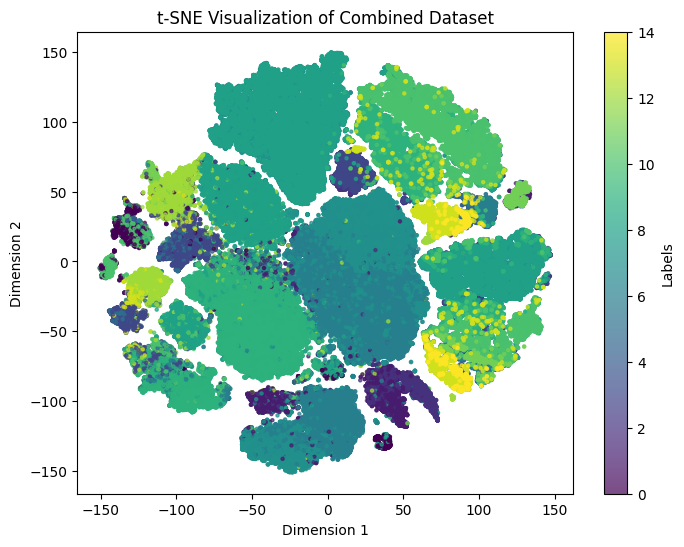

In [ ]:
from openTSNE import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Combine labeled and unlabeled data with predicted labels
def combine_dataset(x_labeled, y_labeled, x_unlabeled, y_unlab_pred):

    labeled_data = pd.DataFrame(x_labeled)
    labeled_data['label'] = y_labeled

    unlabeled_data = pd.DataFrame(x_unlabeled)
    unlabeled_data['label'] = y_unlab_pred

    combined_dataset = pd.concat([labeled_data, unlabeled_data], ignore_index=True)
    return combined_dataset

# Generate t-SNE visualization
def plot_tsne_opentsne(features, labels, title="t-SNE Visualization"):

    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    tsne_result = tsne.fit(features)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis', s=5, alpha=0.7)
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.colorbar(scatter, label='Labels')
    plt.show()

# Combine the labeled and unlabeled data
combined_dataset = combine_dataset(
    x_labeled=x_labeled.to_numpy(),
    y_labeled=y_labeled.to_numpy(),
    x_unlabeled=x_unlabeled_scaled,
    y_unlab_pred=y_unlab_pred
)

# Extract features and labels for t-SNE
features = combined_dataset.drop(columns=['label']).to_numpy()
labels = combined_dataset['label'].to_numpy()

# Generate t-SNE plot
plot_tsne_opentsne(features, labels, title="t-SNE Visualization of Combined Dataset")


<ipython-input-32-4fab101792ea>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_labels))  # Use 'tab10' for up to 10 unique colors


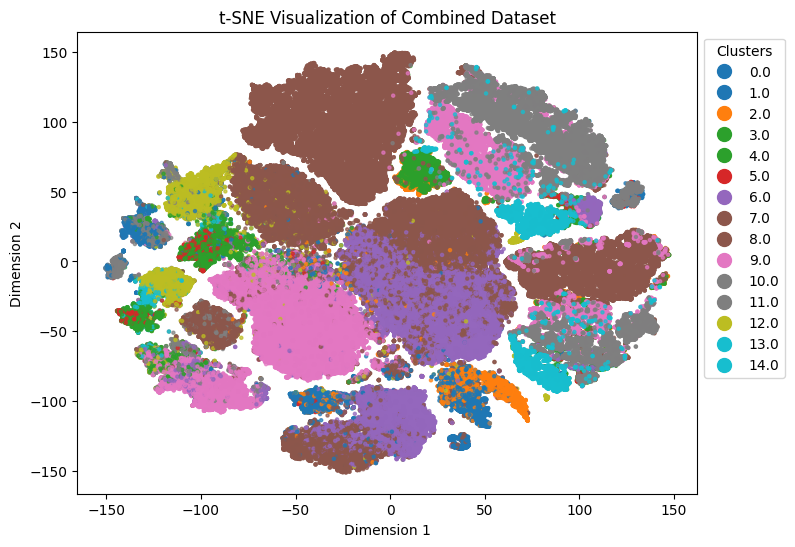

In [ ]:
from openTSNE import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import colors

# Combine labeled and unlabeled data with predicted labels
def combine_dataset(x_labeled, y_labeled, x_unlabeled, y_unlab_pred):
    labeled_data = pd.DataFrame(x_labeled)
    labeled_data['label'] = y_labeled

    unlabeled_data = pd.DataFrame(x_unlabeled)
    unlabeled_data['label'] = y_unlab_pred

    combined_dataset = pd.concat([labeled_data, unlabeled_data], ignore_index=True)
    return combined_dataset

# Generate t-SNE visualization with distinct cluster colors
def plot_tsne_opentsne(features, labels, title="t-SNE Visualization"):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    tsne_result = tsne.fit(features)

    # Ensure labels are integers for discrete colormap
    unique_labels = np.unique(labels)
    label_to_color = {label: idx for idx, label in enumerate(unique_labels)}

    # Map each label to a discrete color index
    discrete_colors = np.array([label_to_color[label] for label in labels])

    # Generate a discrete colormap
    cmap = plt.cm.get_cmap('tab10', len(unique_labels))  # Use 'tab10' for up to 10 unique colors

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=discrete_colors, cmap=cmap, s=5, alpha=0.7)
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    # Add a legend for clusters
    handles = [plt.Line2D([], [], marker='o', color=cmap(idx / len(unique_labels)), linestyle='', markersize=10) for idx in range(len(unique_labels))]
    plt.legend(handles, unique_labels, title="Clusters", loc="best", bbox_to_anchor=(1, 1))
    plt.show()

# Combine the labeled and unlabeled data
combined_dataset = combine_dataset(
    x_labeled=x_labeled.to_numpy(),
    y_labeled=y_labeled.to_numpy(),
    x_unlabeled=x_unlabeled_scaled,
    y_unlab_pred=y_unlab_pred
)

# Extract features and labels for t-SNE
features = combined_dataset.drop(columns=['label']).to_numpy()
labels = combined_dataset['label'].to_numpy()

# Generate t-SNE plot with distinct cluster colors
plot_tsne_opentsne(features, labels, title="t-SNE Visualization of Combined Dataset")


In [ ]:
def generate_unlabeled_predictions(x_unlab, encoder, predictor):
  x_unlab_encoded = encoder.predict(x_unlab)
  _, y_unlab_hat = predictor(x_unlab_encoded, training=False)
  y_unlab_pred = np.argmax(y_unlab_hat, axis=1)
  return y_unlab_pred
'''
performance metric -> generate unlabeled predictions -> inout prediction labels for the unlabeled part of the dataset
generate tsne for this new dataset
'''

'\nperformance metric -> generate unlabeled predictions -> inout prediction labels for the unlabeled part of the dataset\ngenerate tsne for this new dataset\n'

In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
from openTSNE import TSNE
import matplotlib.pyplot as plt
from matplotlib import colors
from tensorflow.keras.models import load_model

# Assuming x_unlabeled_scaled and trained_model are already available in your session
# Example: x_unlabeled_scaled = scaler.fit_transform(x_unlabeled)

# Helper functions
def generate_unlabeled_predictions(x_unlab, encoder, predictor):
    """Generate predictions for unlabeled data."""
    # Encode unlabeled data
    x_unlab_encoded = encoder.predict(x_unlab)
    # Predict with the classifier
    _, y_unlab_hat = predictor(x_unlab_encoded, training=False)
    # Convert probabilities to predicted class labels
    y_unlab_pred = np.argmax(y_unlab_hat, axis=1)
    return y_unlab_pred

def plot_tsne_opentsne(features, labels, title="t-SNE Visualization"):
    """Generate t-SNE visualization with distinct cluster colors."""
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    tsne_result = tsne.fit(features)

    unique_labels = np.unique(labels)
    label_to_color = {label: idx for idx, label in enumerate(unique_labels)}
    discrete_colors = np.array([label_to_color[label] for label in labels])

    cmap = plt.cm.get_cmap('tab10', len(unique_labels))
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=discrete_colors, cmap=cmap, s=5, alpha=0.7)
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    # Add a legend for clusters
    handles = [plt.Line2D([], [], marker='o', color=cmap(idx / len(unique_labels)), linestyle='', markersize=10) for idx in range(len(unique_labels))]
    plt.legend(handles, unique_labels, title="Clusters", loc="best", bbox_to_anchor=(1, 1))
    plt.close()  # Close the figure to avoid overlapping in Gradio
    return plt

# Define Gradio function
def process_and_visualize(dataframe):
    """
    Process the input dataframe, predict labels, and visualize with t-SNE.
    """
    # Ensure the input is a DataFrame
    if not isinstance(dataframe, pd.DataFrame):
        return "Input must be a pandas DataFrame!"

    # Select 100 rows from the input DataFrame
    dataframe_subset = dataframe.iloc[:100]

    # Ensure model and encoder are preloaded
    encoder = load_model("encoder_model.h5")  # Load pre-trained encoder
    predictor = trained_model  # Assume predictor is already trained

    # Convert DataFrame to NumPy array for predictions
    features = dataframe_subset.to_numpy()
    predicted_labels = generate_unlabeled_predictions(features, encoder, predictor)

    # Create t-SNE visualization
    tsne_plot = plot_tsne_opentsne(features, predicted_labels, title="t-SNE Visualization of Input Data")

    # Return the visualization and predictions
    return tsne_plot, pd.DataFrame({"Predicted Labels": predicted_labels}).head(10)

# Initialize Gradio Interface
inputs = gr.Dataframe(headers=None, label="Input Data (100 rows max)", datatype="number")
outputs = [
    gr.Plot(label="t-SNE Visualization"),
    gr.Dataframe(label="Predicted Labels (Top 10)")
]

gr.Interface(
    fn=process_and_visualize,
    inputs=inputs,
    outputs=outputs,
    title="Self-Supervised Learning Visualizer",
    description="Upload a subset of the unlabeled dataset for visualization and prediction."
).launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6911f7812e5b34846e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
from openTSNE import TSNE
import matplotlib.pyplot as plt
from matplotlib import colormaps  # Import for the updated colormap handling
from tensorflow.keras.models import load_model

import io  # For creating image buffers





def plot_tsne_opentsne(features, labels, title="t-SNE Visualization"):
    """Generate t-SNE visualization with distinct cluster colors."""
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    tsne_result = tsne.fit(features)

    unique_labels = np.unique(labels)
    label_to_color = {label: idx for idx, label in enumerate(unique_labels)}
    discrete_colors = np.array([label_to_color[label] for label in labels])

    cmap = colormaps.get_cmap('tab10')  # Get the colormap
    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(
        tsne_result[:, 0],
        tsne_result[:, 1],
        c=discrete_colors,
        cmap=cmap,
        s=5,
        alpha=0.7
    )
    ax.set_title(title)
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

    # Add a legend for clusters
    handles = [
        plt.Line2D([], [], marker='o', color=cmap(idx / len(unique_labels)), linestyle='', markersize=10)
        for idx in range(len(unique_labels))
    ]
    ax.legend(handles, unique_labels, title="Clusters", loc="best", bbox_to_anchor=(1, 1))

    return fig



# Define Gradio function
def process_and_visualize():
    """
    Process the `x_unlabeled` variable, predict labels, and visualize with t-SNE.
    """
    # Ensure x_unlabeled is preloaded
    global x_unlabeled

    # Select 100 rows from x_unlabeled
    x_unlabeled_subset = x_unlabeled[:500]

    # Ensure model and encoder are preloaded
    encoder = load_model(encoder_path)  # Load pre-trained encoder
    predictor = trained_model  # Assume predictor is already trained

    # Generate predictions
    predicted_labels = generate_unlabeled_predictions(x_unlabeled_subset, encoder, predictor)


    tsne_plot = plot_tsne_opentsne(x_unlabeled_subset, predicted_labels, title="t-SNE Visualization of Input Data")

    # Return the visualization and predictions
    return tsne_plot, pd.DataFrame({"Predicted Labels": predicted_labels}).head(10)

# Initialize Gradio Interface
outputs = [
    gr.Plot(label="t-SNE Visualization"),
    gr.Dataframe(label="Predicted Labels (Top 10)")
]

gr.Interface(
    fn=process_and_visualize,
    inputs=None,  # No user inputs required
    outputs=outputs,
    title="Self-Supervised Learning Visualizer",
    description="Automatically processes the `x_unlabeled` dataset for visualization and prediction."
).launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8071ef3a6b3cb6f052.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
from openTSNE import TSNE
import matplotlib.pyplot as plt
from matplotlib import colormaps  # Import for the updated colormap handling
from tensorflow.keras.models import load_model

# Define function to generate predictions for unlabeled data
def generate_unlabeled_predictions(x_unlab, encoder, predictor):
    """Generate predictions for unlabeled data."""
    x_unlab_encoded = encoder.predict(x_unlab)  # Encode unlabeled data
    _, y_unlab_hat = predictor(x_unlab_encoded, training=False)  # Predict with classifier
    y_unlab_pred = np.argmax(y_unlab_hat, axis=1)  # Get predicted class labels
    return y_unlab_pred

# Define the function for t-SNE visualization
def plot_tsne_opentsne(features, labels, title="t-SNE Visualization"):
    """Generate t-SNE visualization with distinct cluster colors."""
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    tsne_result = tsne.fit(features)

    unique_labels = np.unique(labels)
    label_to_color = {label: idx for idx, label in enumerate(unique_labels)}
    discrete_colors = np.array([label_to_color[label] for label in labels])

    cmap = colormaps.get_cmap('tab10')  # Get the colormap
    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(
        tsne_result[:, 0],
        tsne_result[:, 1],
        c=discrete_colors,
        cmap=cmap,
        s=5,
        alpha=0.7
    )
    ax.set_title(title)
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

    # Add a legend for clusters
    handles = [
        plt.Line2D([], [], marker='o', color=cmap(idx / len(unique_labels)), linestyle='', markersize=10)
        for idx in range(len(unique_labels))
    ]
    ax.legend(handles, unique_labels, title="Clusters", loc="best", bbox_to_anchor=(1, 1))

    return fig

# Define Gradio function to process and visualize
def process_and_visualize(start_row, end_row):
    """
    Process the `x_unlabeled` variable, predict labels, and visualize with t-SNE.
    Takes a range of rows as input from the user.
    """
    # Ensure x_unlabeled is preloaded
    global x_unlabeled

    # Convert input to integers
    start_row = int(start_row)
    end_row = int(end_row)

    # Select rows from x_unlabeled based on the provided range
    x_unlabeled_subset = x_unlabeled[start_row:end_row]

    # Ensure model and encoder are preloaded
    encoder = load_model(encoder_path)  # Load pre-trained encoder
    predictor = trained_model  # Assume predictor is already trained

    # Generate predictions
    predicted_labels = generate_unlabeled_predictions(x_unlabeled_subset, encoder, predictor)

    # Create t-SNE visualization
    tsne_plot = plot_tsne_opentsne(x_unlabeled_subset, predicted_labels, title="t-SNE Visualization of Input Data")

    # Return the visualization and predictions
    return tsne_plot, pd.DataFrame({"Predicted Labels": predicted_labels}).head(10)

# Initialize Gradio Interface
inputs = [
    gr.Number(label="Start Row", value=3, precision=0),  # Input for the starting row
    gr.Number(label="End Row", value=109, precision=0)   # Input for the ending row
]

outputs = [
    gr.Plot(label="t-SNE Visualization"),
    gr.Dataframe(label="Predicted Labels (Top 10)")
]

gr.Interface(
    fn=process_and_visualize,
    inputs=inputs,  # Use the range inputs
    outputs=outputs,
    title="Self-Supervised Learning Visualizer",
    description="Automatically processes the `x_unlabeled` dataset for visualization and prediction."
).launch(debug=True)
